# Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv("Merged_Cleansed\df_train.csv")
SPY = pd.read_csv("Merged_Cleansed\SPY_train.csv")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df.head(3)

,PERMNO,Date,TICKER,Price,Return,Shares Outstanding,Turnover,Dollar Turnover,Current Ratio,Cash Ratio,Quick Ratio,Revenue Growth,COGS Growth,Operating Income Growth,Net Income Growth,EPS Basic Growth,Net Operating Cash Flow Growth
0,10051,1999-01-01,HGR,22.5000,0.111111,18179,0.701029,15.773145,3.014681,0.392692,2.327885,0.040000,0.030781,0.085278,0.138436,0.043478,0.593825
1,10051,1999-02-01,HGR,25.0000,-0.392500,18179,0.526817,13.170416,3.014681,0.392692,2.327885,0.040000,0.030781,0.085278,0.138436,0.043478,0.593825
2,10051,1999-03-01,HGR,15.1875,-0.111111,18179,1.615710,24.538602,3.161060,0.215989,2.402887,0.054699,0.016057,0.088484,0.069417,0.000000,0.329531


In [4]:
SPY.head(3)

,Date,Return
0,1995-01-01,0.012817
1,1995-02-01,0.024591
2,1995-03-01,0.032419


In [5]:
print(df.shape)
print(SPY.shape)

(306608, 17)
(252, 2)


# Explore Correlation

## Liquidity Correlation

In [6]:
df.iloc[:, 6:11].corr()

,Turnover,Dollar Turnover,Current Ratio,Cash Ratio,Quick Ratio
Turnover,1.000000,0.617226,0.015797,0.036817,0.005285
Dollar Turnover,0.617226,1.000000,0.002169,0.020328,-0.002200
Current Ratio,0.015797,0.002169,1.000000,0.705459,0.932293
Cash Ratio,0.036817,0.020328,0.705459,1.000000,0.712009
Quick Ratio,0.005285,-0.002200,0.932293,0.712009,1.000000


## Growth Correlation

In [7]:
df.iloc[:, 11:].corr()

,Revenue Growth,COGS Growth,Operating Income Growth,Net Income Growth,EPS Basic Growth,Net Operating Cash Flow Growth
Revenue Growth,1.000000,0.021796,-0.000561,-0.000164,-0.000627,0.001436
COGS Growth,0.021796,1.000000,0.010015,0.004023,-0.007029,0.000387
Operating Income Growth,-0.000561,0.010015,1.000000,-0.013414,-0.005418,-0.000209
Net Income Growth,-0.000164,0.004023,-0.013414,1.000000,0.193395,-0.000714
EPS Basic Growth,-0.000627,-0.007029,-0.005418,0.193395,1.000000,-0.002021
Net Operating Cash Flow Growth,0.001436,0.000387,-0.000209,-0.000714,-0.002021,1.000000


# Run Regression

In [8]:
import statsmodels.api as sm
df_ = df.copy()
df_.dropna(inplace=True)
cols = list(df.columns[6:])
X = df_.copy()[cols]
X = sm.add_constant(X)
y = df_.copy()['Return']

Model = sm.OLS(y, X)
Result = Model.fit()
print(Result.summary())

D:\Anaconda\Setup\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.77
Date:                Wed, 11 Mar 2020   Prob (F-statistic):           6.56e-36
Time:                        17:40:42   Log-Likelihood:             2.0614e+05
No. Observations:              306608   AIC:                        -4.123e+05
Df Residuals:                  306596   BIC:                        -4.121e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

From Regression Table, We can initially know that:
"Turnover", "COGS Growth" have significant positive impact on Return
"Dollar Turnover", "EPS Basic Growth" have significant negative impact on Return

# Rank for factor

## Date Processing

In [9]:
# Transform Date into datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

SPY['Date'] = pd.to_datetime(SPY['Date'])
SPY.set_index('Date', inplace=True)

In [10]:
# Construct Date List
Date = []
for i in range(1995, 2016):
    for j in range(1, 13):
        date = str(i) + '-' + str(j)
        Date.append(date)
        
Date = Date[1:]

## Define Rank Function and Use it to rank for each factor

In [11]:
def percentile_to_score(value):
    if value >= 0.9: value = 1
    elif value >= 0.8: value = 2
    elif value >= 0.7: value = 3
    elif value >= 0.6: value = 4
    elif value >= 0.5: value = 5
    elif value >= 0.4: value = 6
    elif value >= 0.3: value = 7
    elif value >= 0.2: value = 8
    elif value >= 0.1: value = 9
    elif value >= 0.0: value = 10
    return value 

def Rank(df_, factor, factor_rank, Date):
    df = df_.copy()
        
    # First, we select the first date's dataframe and rank
    dataframe = df[Date[0]].copy()
#     dataframe = dataframe.sort_values(by = [factor], axis = 0, ascending = False)  # Sort by Turnover
#     dataframe[factor_rank] = range(len(dataframe))  
#     dataframe[factor_rank] += 1 
    dataframe[factor_rank] = dataframe[factor].rank(pct=True).apply(lambda x: percentile_to_score(x))
    
    for i in range(1, len(Date)):
        DF = df[Date[i]].copy()  # Divide the big df into small DF by date
#         DF = DF.sort_values(by = [factor], axis = 0, ascending = False)  # Sort by Turnover
#         DF[factor_rank] = range(len(DF))  
#         DF[factor_rank] += 1 
        DF[factor_rank] = DF[factor].rank(pct=True).apply(lambda x: percentile_to_score(x))
        dataframe = pd.concat([dataframe, DF])
    
    return dataframe

In [12]:
Factor_List = list(df.columns[5:])
Factor_Rank = []

for factor in Factor_List:
    factor_rank = factor + " Rank"
    Factor_Rank.append(factor_rank)
    df = Rank(df, factor, factor_rank, Date)   # Rank for each factor

In [13]:
df.head(3)

,PERMNO,TICKER,Price,Return,Shares Outstanding,Turnover,Dollar Turnover,Current Ratio,Cash Ratio,Quick Ratio,Revenue Growth,COGS Growth,Operating Income Growth,Net Income Growth,EPS Basic Growth,Net Operating Cash Flow Growth,Turnover Rank,Dollar Turnover Rank,Current Ratio Rank,Cash Ratio Rank,Quick Ratio Rank,Revenue Growth Rank,COGS Growth Rank,Operating Income Growth Rank,Net Income Growth Rank,EPS Basic Growth Rank,Net Operating Cash Flow Growth Rank
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-02-01,10057,AMT,15.625,-0.072000,6300,1.752063,27.375992,2.353802,1.023869,1.736129,-0.031245,-0.072984,-0.484988,-0.139967,-0.782609,3.746730,1,2,3,2,3,8,9,10,7,9,1
1995-02-01,10064,TTI,4.750,0.157895,34703,1.133504,5.384145,1.551626,0.135192,1.257590,0.521483,0.637787,0.870256,-7.713339,-14.000000,1.039793,2,8,6,6,4,1,1,1,10,10,3
1995-02-01,10145,ALD,35.750,0.064895,282987,0.405047,14.480426,1.352109,0.149808,0.838101,-0.024161,-0.012927,-0.056433,-0.035714,-0.028986,0.922078,6,4,7,6,8,8,8,8,6,6,3


In [14]:
#df_ = df.copy()
for factor in Factor_List:
    #del df_[factor]
    del df[factor]
    
df.head(3)

,PERMNO,TICKER,Price,Return,Shares Outstanding,Turnover Rank,Dollar Turnover Rank,Current Ratio Rank,Cash Ratio Rank,Quick Ratio Rank,Revenue Growth Rank,COGS Growth Rank,Operating Income Growth Rank,Net Income Growth Rank,EPS Basic Growth Rank,Net Operating Cash Flow Growth Rank
Date,,,,,,,,,,,,,,,,
1995-02-01,10057,AMT,15.625,-0.072000,6300,1,2,3,2,3,8,9,10,7,9,1
1995-02-01,10064,TTI,4.750,0.157895,34703,2,8,6,6,4,1,1,1,10,10,3
1995-02-01,10145,ALD,35.750,0.064895,282987,6,4,7,6,8,8,8,8,6,6,3


# Select Stocks based on Rank

In [15]:
class Solve():
    def __init__(self, df, SPY, Date, Factor_Rank):
        self.df = df
        self.SPY = SPY
        self.Date = Date
        self.Factor_Rank = Factor_Rank
               
    def Get_Returns(self):
        self.df_ = self.df.copy()
        self.Returns = {} # Used to store each factor's return for each month
        self.Excesses = {} # Used to store each factor's return for each excess month
           
        for factor in self.Factor_Rank:
            Return = []  # Used to store return for each month
            Excess = []  # Used to store excess return for each month
            for date in Date:
                DF = self.df_[date].copy()  # Divide the big df into small DF by date
                N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
                DF = DF.sort_values(by = [factor], axis = 0, ascending = True)  # Sort by Turnover
                #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
                profit = DF.iloc[int(0.1*N):int(1.1*N)]['Return'].mean()
                #profit = DF.iloc[-N:]['Return'].mean()
                profit_SPY = self.SPY[date]['Return'].values[0]

                Return.append( profit )
                Excess.append( profit - profit_SPY )

            self.Returns[factor] = Return 
            self.Excesses[factor] = Excess

    def Return_Summary(self):
        print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
        print("=============++++++++++++++=============")
        
        for key in self.Factor_Rank:
            print("=============" + key + "=============")
            print("Summary for Return:"); print(pd.Series(self.Returns[key]).describe(), "\n")
            print("Summary for Excess Return:"); print(pd.Series(self.Excesses[key]).describe())
            print("=============++++++++++++++=============")
        
    def T_Test(self):
        from scipy import stats
        print("==============================++++++++++++++==============================")
        for factor in self.Factor_Rank:
            print("Result of T Test for " + factor + ":")
            print(stats.ttest_1samp(self.Excesses[factor], 0))
            print("==============================++++++++++++++==============================")
            
    def Plot_hist_Return(self):
        plt.figure(figsize=(15,3))
        count = 0
        
        for key in self.Factor_Rank:
            count += 1
            ax = plt.subplot(13,2,count)
            plt.hist(self.Returns[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of Return from' + key)
            
            count += 1
            ax = plt.subplot(13,2,count)
            plt.hist(self.Excesses[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of Excess Return from' + key)


    def Plot_Cum_Return(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Returns[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Returns for each Factor',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_Excess(self):

        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Excesses[factor])+1).cumprod()-1, label = factor) 
 
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Excess Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Returns for each Factor',fontsize =15)

        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]

        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)

In [16]:
Object = Solve(df, SPY, Date, Factor_Rank)

## Calculate Returns and Excess Returns

In [17]:
Object.Get_Returns()

## Give a Summary for all Factors' Return and Excess

In [18]:
Object.Return_Summary()

Summary for SPY Return:
count    252.000000
mean       0.007206
std        0.046654
min       -0.167743
25%       -0.019238
50%        0.012929
75%        0.034528
max        0.157330
Name: Return, dtype: float64
=============++++++++++++++=============
=============Turnover Rank=============
Summary for Return:
count    251.000000
mean       0.014982
std        0.071938
min       -0.257557
25%       -0.030054
50%        0.015877
75%        0.061338
max        0.287312
dtype: float64 

Summary for Excess Return:
count    251.000000
mean       0.007798
std        0.081722
min       -0.226108
25%       -0.047297
50%        0.006991
75%        0.053589
max        0.301197
dtype: float64
=============++++++++++++++=============
=============Dollar Turnover Rank=============
Summary for Return:
count    251.000000
mean       0.011191
std        0.056206
min       -0.249287
25%       -0.023078
50%        0.014460
75%        0.052539
max        0.153326
dtype: float64 

Summary for Excess Ret

In [19]:
Object.T_Test()

==============================++++++++++++++==============================
Result of T Test for Turnover Rank:
Ttest_1sampResult(statistic=1.5117866545289629, pvalue=0.1318511540453698)
==============================++++++++++++++==============================
Result of T Test for Dollar Turnover Rank:
Ttest_1sampResult(statistic=0.929179789967263, pvalue=0.35369220835922954)
==============================++++++++++++++==============================
Result of T Test for Current Ratio Rank:
Ttest_1sampResult(statistic=1.0489743371103966, pvalue=0.295202933149773)
==============================++++++++++++++==============================
Result of T Test for Cash Ratio Rank:
Ttest_1sampResult(statistic=1.4449350228385764, pvalue=0.14972836557087388)
==============================++++++++++++++==============================
Result of T Test for Quick Ratio Rank:
Ttest_1sampResult(statistic=1.2011327436423869, pvalue=0.23083643523556135)
==============================++++++++++++++========

## Plot Cumulative Return for each Factor

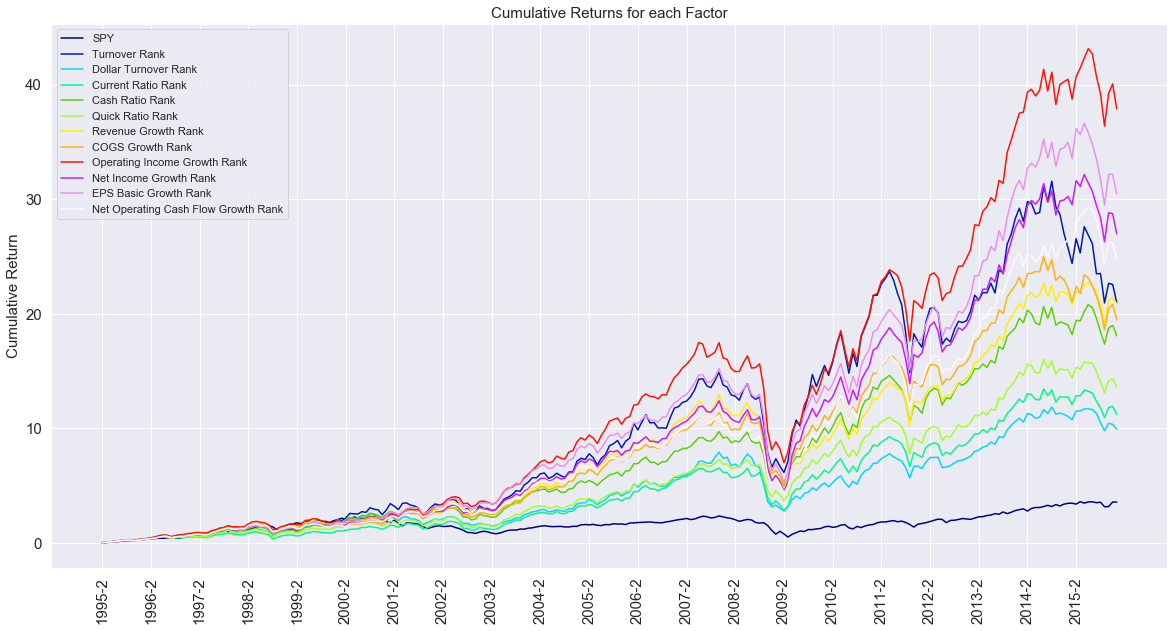

In [20]:
Object.Plot_Cum_Return()

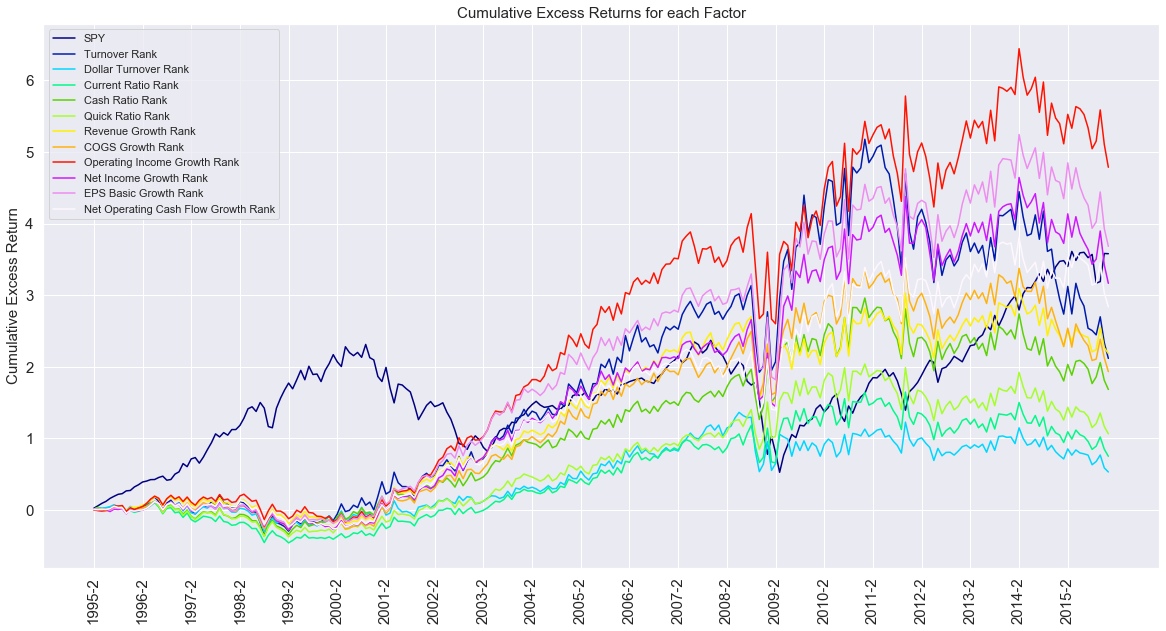

In [21]:
Object.Plot_Cum_Excess()

# Combine Factors

In [22]:
class Combine():
    def __init__(self, df, SPY, Date):
        self.df = df
        self.SPY = SPY
        self.Date = Date
        
    def Combine_Factors(self):
        self.data = self.df.copy()
        self.data['Liquid Ratio Rank'] = (self.data['Cash Ratio Rank'] + self.data['Current Ratio Rank'] + self.data['Quick Ratio Rank']) / 3 
        self.data['Turnover Combine Rank'] = (self.data['Turnover Rank'] + self.data['Dollar Turnover Rank']) / 2
        self.data['Income Combine Rank'] = (self.data['COGS Growth Rank'] + self.data['Operating Income Growth Rank'] + self.data['Net Income Growth Rank']) / 3
        
        self.data['Total Rank'] = (self.data['Revenue Growth Rank'] + self.data['Income Combine Rank'] +
                                   self.data['EPS Basic Growth Rank'] + self.data['Net Operating Cash Flow Growth Rank'] + self.data['Liquid Ratio Rank'] +
                                   self.data['Income Combine Rank']) / 6
               
    def Get_Returns(self):
        self.data_ = self.data.copy()
           
        self.Return = []  # Used to store return for each month
        self.Excess = []  # Used to store excess return for each month
        for date in Date:
            DF = self.data_[date].copy()  # Divide the big df into small DF by date
            N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
            DF = DF.sort_values(by = ['Total Rank'], axis = 0, ascending = True)  # Sort by Turnover
            #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
            profit = DF.iloc[int(0.1*N):int(1.1*N)]['Return'].mean()
            #profit = DF.iloc[-N:]['Return'].mean()
            profit_SPY = self.SPY[date]['Return'].values[0]

            self.Return.append( profit )
            self.Excess.append( profit - profit_SPY )

    def Return_Summary(self):
        print("=============++++++++++++++=============")
        print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
        print("=============++++++++++++++=============")
        print("Summary for Return:")
        print(pd.Series(self.Return).describe())
        print("=============++++++++++++++=============")
        print("Summary for Excess Return:")
        print(pd.Series(self.Excess).describe())
        print("=============++++++++++++++=============")
        
    def T_Test(self):
        from scipy import stats
        print("==============================++++++++++++++==============================")
        print("Result of T Test")
        print(stats.ttest_1samp(self.Excess, 0))
        print("==============================++++++++++++++==============================")
            
    def Plot_hist_Return(self):
        plt.figure(figsize=(15,4))
        ax1 = plt.subplot(1,3,1)
        plt.hist(self.Return, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of Return')
            
        ax2 = plt.subplot(1,3,2)
        plt.hist(self.Excess, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of Excess Return') 
        
        ax3 = plt.subplot(1,3,3)
        plt.hist(self.SPY['Return'].values, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of SPY Return') 

    def Plot_Cum_Return(self):
        fig1 = plt.figure(figsize = (15, 6))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY Return')
        
        plt.plot(self.Date, (pd.Series(self.Return)+1).cumprod()-1, label = 'Return')   
        plt.plot(self.Date, (pd.Series(self.Excess)+1).cumprod()-1, label = 'Excess Return') 
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Return for Combine Factor',fontsize =15)
        
        ax1.legend(loc=2)

In [23]:
Object2 = Combine(df, SPY, Date)

## Combine All these Factors into one

In [24]:
Object2.Combine_Factors()

## Calculate Return

In [25]:
Object2.Get_Returns()

## Give a Summary for Return and T Test for Excess Return

In [26]:
Object2.Return_Summary()

=============++++++++++++++=============
Summary for SPY Return:
count    252.000000
mean       0.007206
std        0.046654
min       -0.167743
25%       -0.019238
50%        0.012929
75%        0.034528
max        0.157330
Name: Return, dtype: float64
=============++++++++++++++=============
Summary for Return:
count    251.000000
mean       0.014148
std        0.054285
min       -0.247077
25%       -0.016106
50%        0.019709
75%        0.047553
max        0.181925
dtype: float64
=============++++++++++++++=============
Summary for Excess Return:
count    251.000000
mean       0.006964
std        0.064779
min       -0.220412
25%       -0.036231
50%        0.008235
75%        0.040105
max        0.269262
dtype: float64
=============++++++++++++++=============


In [27]:
Object2.T_Test()

==============================++++++++++++++==============================
Result of T Test
Ttest_1sampResult(statistic=1.7032931045360447, pvalue=0.08975596034101206)
==============================++++++++++++++==============================


## Plot Cumulative Return

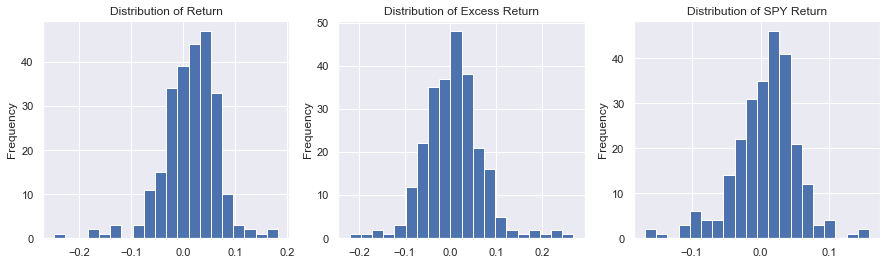

In [28]:
Object2.Plot_hist_Return()

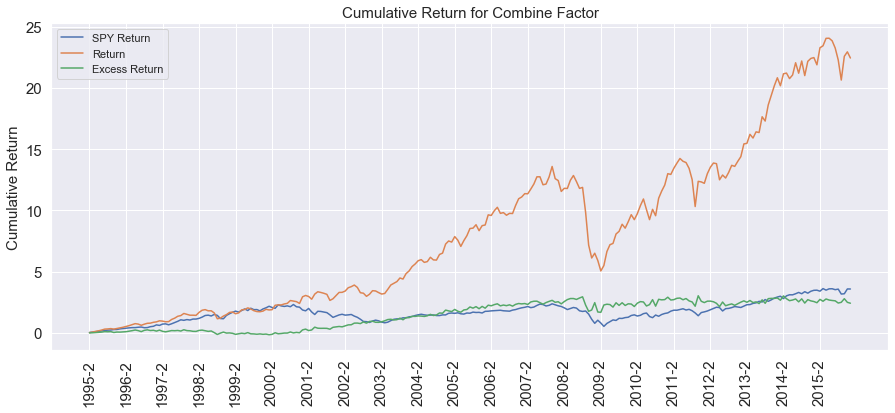

In [29]:
Object2.Plot_Cum_Return()